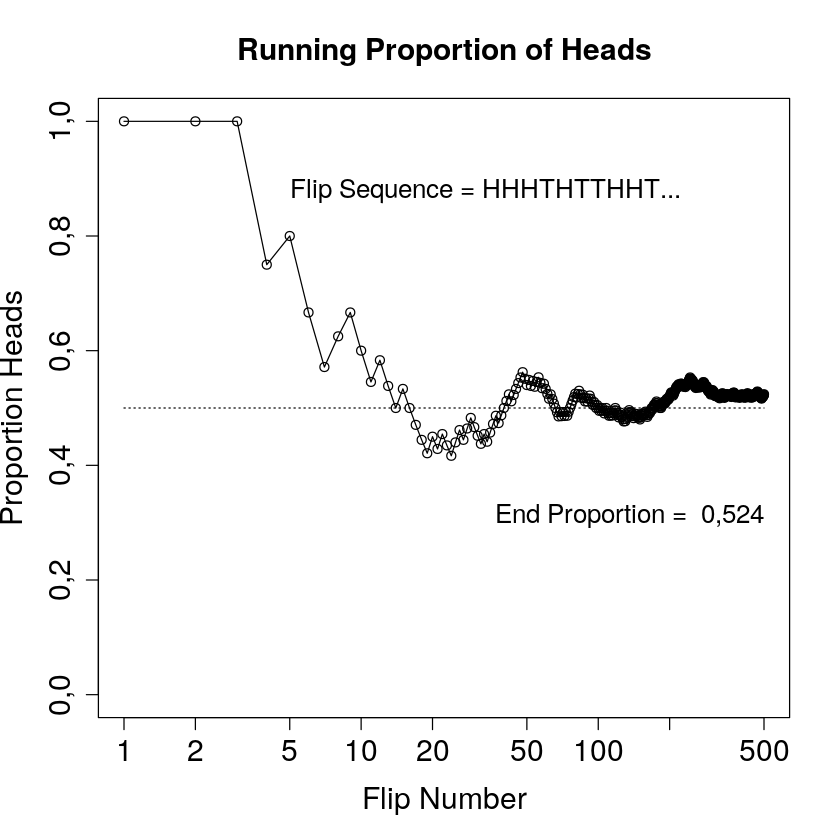

In [11]:
N = 500
#set.seed(47405)
flipsequence = sample(x=c(0,1), prob=c(.5,.5), size=N, replace=TRUE)
r = cumsum(flipsequence)
n = 1:N
runprop=r/n
plot(n, runprop, type="o", log="x", xlim=c(1,N), ylim=c(0.0, 1.0),
    cex.axis=1.5, xlab="Flip Number", ylab="Proportion Heads", cex.lab=1.5,
    main="Running Proportion of Heads", cex.main=1.5)

lines(c(1,N), c(.5,.5), lty=3)

flipletters = paste(c("T", "H")[flipsequence[1:10]+1], collapse = "")
displaystring = paste("Flip Sequence = ", flipletters, "...", sep="")
text(5, .9, displaystring, adj=c(0,1), cex=1.3)
text(N, .3, paste("End Proportion = ", runprop[N]), adj = c(1,0), cex = 1.3)


In [10]:
# flipsequence[1:10]
c("T", "H")[c(1,2,1,2,2,1)] # intersting things
# the same by numpy:
# a = np.array([0,1,0,1,1,0])
# b = np.array(['H', 'T'])
# b[a]

[1] "T" "H" "T" "H" "H" "T"

In [12]:
HDIofICDF = function(ICDFname, credMass=0.95, tol=1e-8, ...) {
    incredMass = 1.0 - credMass
    intervalWidth = function(lowTailPr, ICDFname, credMass, ...) {
        ICDFname(credMass+lowTailPr, ...) - ICDFname(lowTailPr, ...)
    }
# The function optimize searches the interval from lower to upper for a minimum or maximum of the function f with respect to its first argument.
#     optimize(f, interval, …, lower = min(interval), upper = max(interval),
#          maximum = FALSE,
#          tol = .Machine$double.eps^0.25)
    
    optInfo = optimize(intervalWidth, c(0, incredMass), ICDFname=ICDFname, credMass=credMass, tol=tol, ...)
    HDIlowTailPr = optInfo$minimum
    return (c(ICDFname(HDIlowTailPr, ...), ICDFname(credMass+HDIlowTailPr, ...)))    
}

In [23]:
# a = c(1,2,3) # 1 2 3
# t = a != 1 # FALSE TRUE TRUE
# t2 = a != 2 # TRUE FALSE TRUE
# t3 = t & t2 # FALSE FALSE TRUE
# # reduces vector to one value
# r = any(t3) # TRUE
# r

[1] TRUE

In [49]:
BernBeta = function(priorShape, dataVec, credMass=0.95, saveGraph=F, plotGraph=F) {
    if (length(priorShape) != 2) {
        stop("priorShape must have two components.")
    }
    if (any(priorShape <= 0)) {
        stop("priorShape components must be positive.")
    }
    if (any(dataVec != 1 & dataVec != 0)) {
        stop("dataVec must be a vector of 1s and 0s.")
    }
    if (credMass <= 0 | credMass >= 1.0) {
        stop("credMass must be between 0 and 1.")
    }
    
    a = priorShape[1]
    b = priorShape[2]
    
    z = sum(dataVec == 1)
    N = length(dataVec)
    
    postShape = c(a+z, b+N-z)
    
    if (!plotGraph) {
        return( postShape )
    }
    
    pData = beta(z+a, N-z+b)/beta(a,b)
    
    hpdLim = HDIofICDF(qbeta, shape1=postShape[1], shape2=postShape[2])
    
    binwidth = 0.005
    Theta = seq(from=binwidth/2, to=1-(binwidth/2), by = binwidth)
    
    pTheta = dbeta(Theta, a, b)
    pDataGivenTheta = Theta^z * (1-Theta)^(N-z)
    pThetaGivenData = dbeta(Theta, a+z, b+N-z)
    
#     windows(7,10)
    layout( matrix( c( 1,2,3 ) ,nrow=3 ,ncol=1 ,byrow=FALSE ) ) # 3x1 panels
    
    par( mar=c(3,3,1,0) , mgp=c(2,1,0) , mai=c(0.5,0.5,0.3,0.1) ) # margin specs
    maxY = max( c(pTheta,pThetaGivenData) ) # max y for plotting
    # Plot the prior.
    plot( Theta , pTheta , type="l" , lwd=3,
         xlim=c(0,1) , ylim=c(0,maxY) , cex.axis=1.2,
         xlab=bquote(theta) , ylab=bquote(p(theta)),
         cex.lab=1.5, main="Prior" , cex.main=1.5 )
    if ( a > b ) {
        textx = 0 ; textadj = c(0,1)
    } else {
        textx = 1 ; textadj = c(1,1)
    }
    
    text( textx , 1.0*max(pThetaGivenData) ,
    bquote( "beta(" * theta * "|" * .(a) * "," * .(b) * ")" ) ,
    cex=2.0 ,adj=textadj )
    # Plot the likelihood: p(data|theta)
    plot( Theta , pDataGivenTheta , type="l" , lwd=3 ,
    xlim=c(0,1) , cex.axis=1.2 , xlab=bquote(theta) ,
    ylim=c(0,1.1*max(pDataGivenTheta)) ,
    ylab=bquote( "p(D|" * theta * ")" ) ,
    cex.lab=1.5 , main="Likelihood" , cex.main=1.5 )
    if ( z > .5*N ) { textx = 0 ; textadj = c(0,1) }
    else { textx = 1 ; textadj = c(1,1) }
    text( textx , 1.0*max(pDataGivenTheta) , cex=2.0 ,
    bquote( "Data: z=" * .(z) * ",N=" * .(N) ) ,adj=textadj )
    # Plot the posterior.
    plot( Theta , pThetaGivenData ,type="l" , lwd=3 ,
    xlim=c(0,1) , ylim=c(0,maxY) , cex.axis=1.2 ,
    xlab=bquote(theta) , ylab=bquote( "p(" * theta * "|D)" ) ,
    cex.lab=1.5 , main="Posterior" , cex.main=1.5 )
    if ( a+z > b+N-z ) { textx = 0 ; textadj = c(0,1) }
    else { textx = 1 ; textadj = c(1,1) }
    text( textx , 1.00*max(pThetaGivenData) , cex=2.0 ,
    bquote( "beta(" * theta * "|" * .(a+z) * "," * .(b+N-z) * ")" ),
        adj=textadj )
    text( textx , 0.75*max(pThetaGivenData) , cex=2.0 ,
    bquote( "p(D)=" * .(signif(pData,3)) ) , adj=textadj )
    # Mark the HDI in the posterior.
    hpdHt = mean( c( dbeta(hpdLim[1],a+z,b+N-z) , dbeta(hpdLim[2],a+z,b+N-z) ))
    lines( c(hpdLim[1],hpdLim[1]) , c(-0.5,hpdHt) , type="l" , lty=2 , lwd=1.5)
    lines( c(hpdLim[2],hpdLim[2]) , c(-0.5,hpdHt) , type="l" , lty=2 , lwd=1.5)
    lines( hpdLim , c(hpdHt,hpdHt) , type="l" , lwd=2 )
    text( mean(hpdLim) , hpdHt , bquote( .(100*credMass) * "% HDI" ) ,
    adj=c(0.5,-1.0) , cex=2.0 )
    text( hpdLim[1] , hpdHt , bquote(.(round(hpdLim[1],3))),
         adj=c(1.1,-0.1) , cex=1.2 )
    text( hpdLim[2] , hpdHt , bquote(.(round(hpdLim[2],3))),
        adj=c(-0.1,-0.1) , cex=1.2 )
    # Construct file name for saved graph, and save the graph.
    if ( saveGraph ) {
        filename = paste( "BernBeta_",a,"_",b,"_",z,"_",N,".eps" ,sep="")
        dev.copy2eps( file = filename )
    }
    return( postShape )
}

[1] 8 7

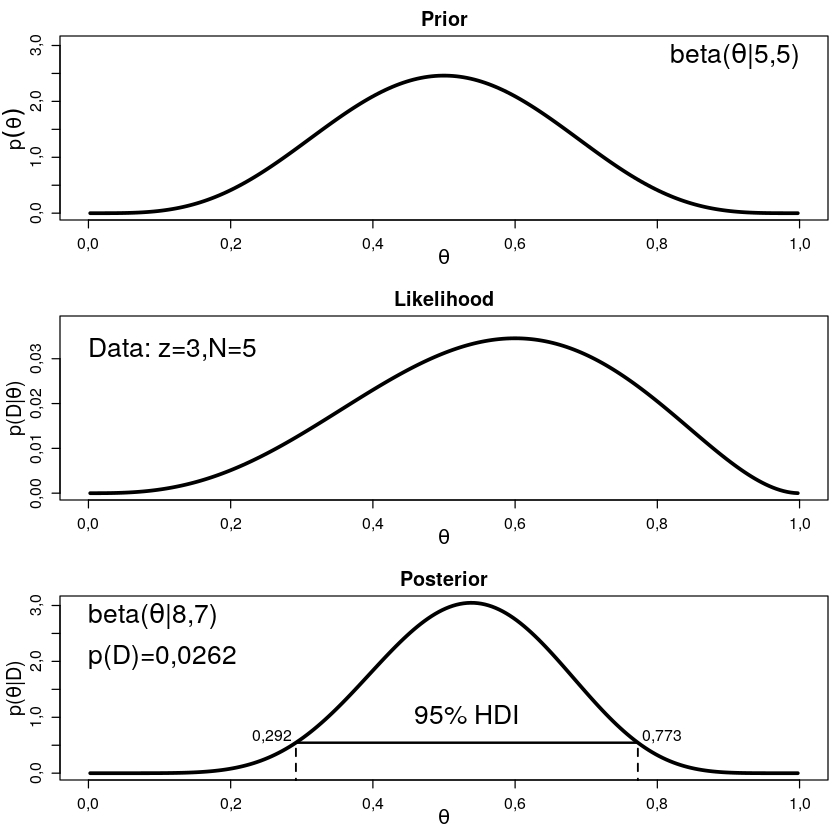

In [50]:
BernBeta(priorShape=c(5,5) , dataVec=c(1,0,0,1,1), plotGraph=T)

## Excercises 5

### Excercise 5.1

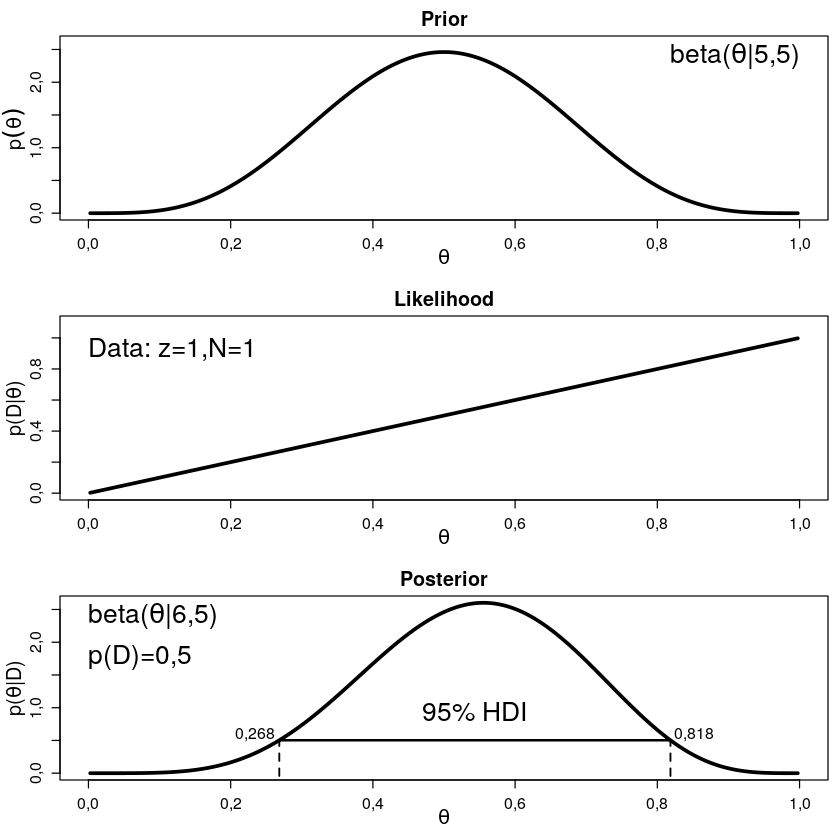

In [55]:
piorShape = c(4,4)
# flips = c(1,1,0)
#flips = c(0,1,1)
flips = c(1,0,1)
postShape = BernBeta(piorShape, c(flips[1]))
postShape = BernBeta(postShape, c(flips[2]))
postShape = BernBeta(postShape, c(flips[3]), plotGraph=T)

### Excercise 5.2

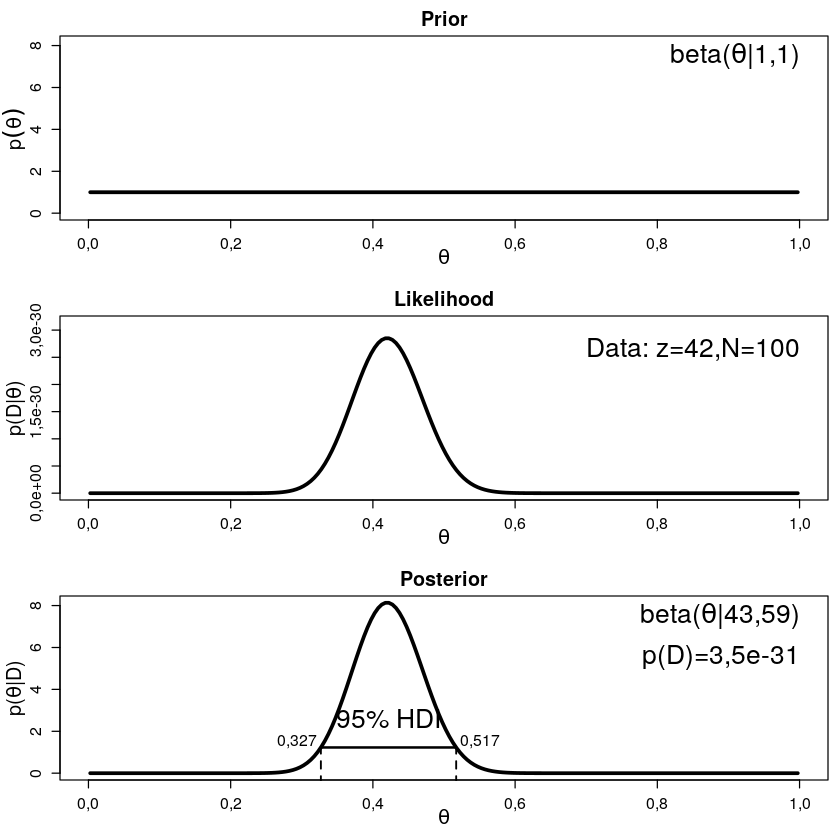

In [58]:
piorShape = c(1,1)
postShape = BernBeta(piorShape, c(rep(c(0), 58), rep(c(1), 42)), plotGraph=T)

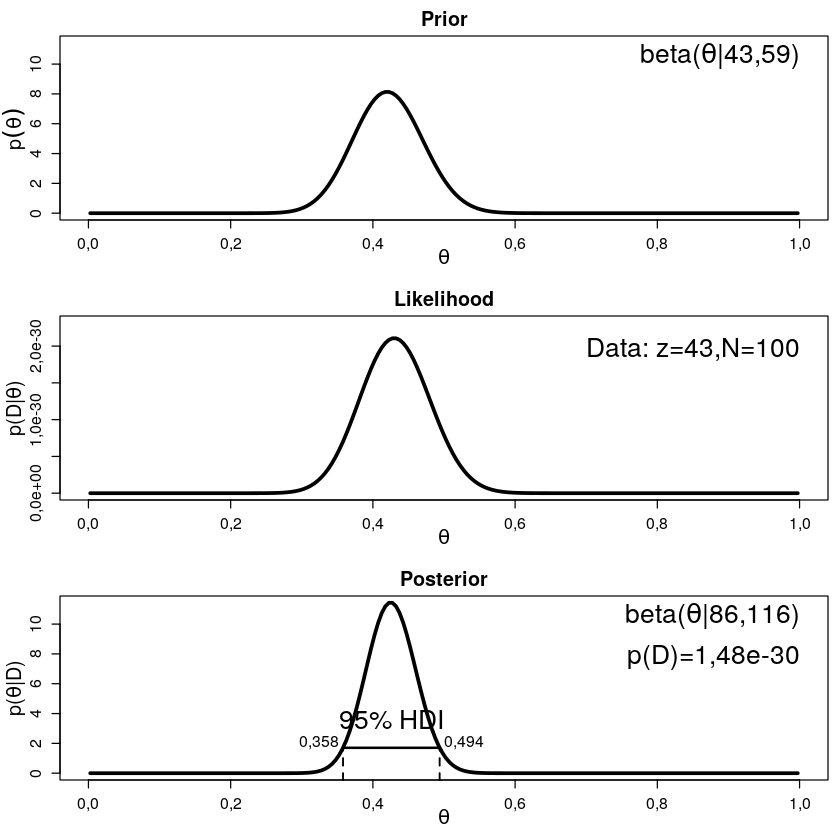

In [59]:
postShape = BernBeta(postShape, c(rep(c(0), 57), rep(c(1), 43)), plotGraph=T)

### Excercise 5.3

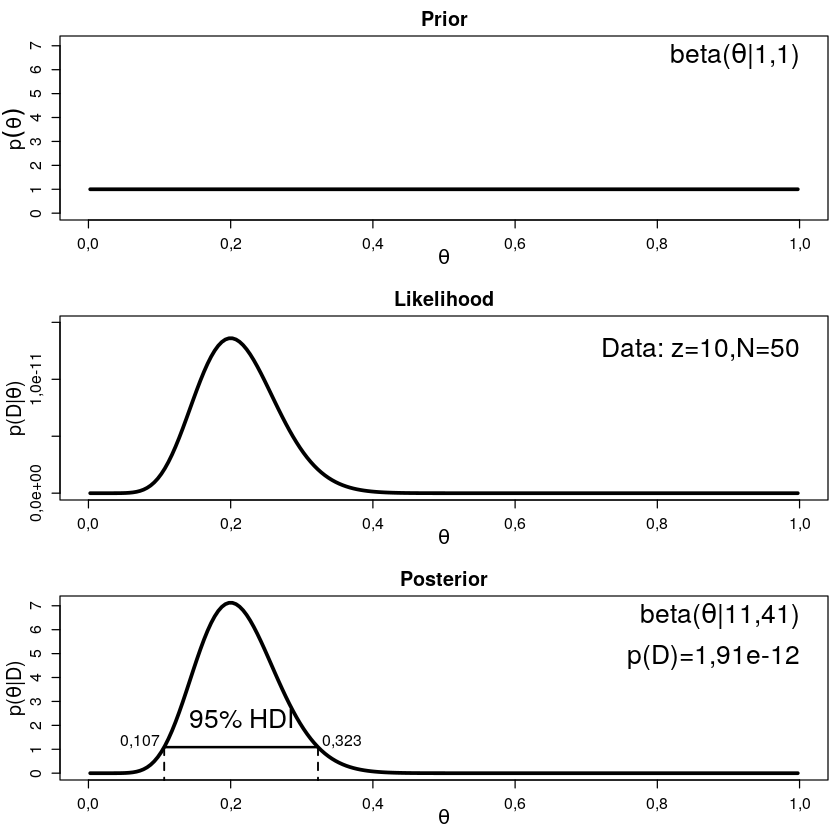

In [60]:
piorShape = c(1,1)
postShape = BernBeta(piorShape, c(rep(c(0), 40), rep(c(1), 10)), plotGraph=T)

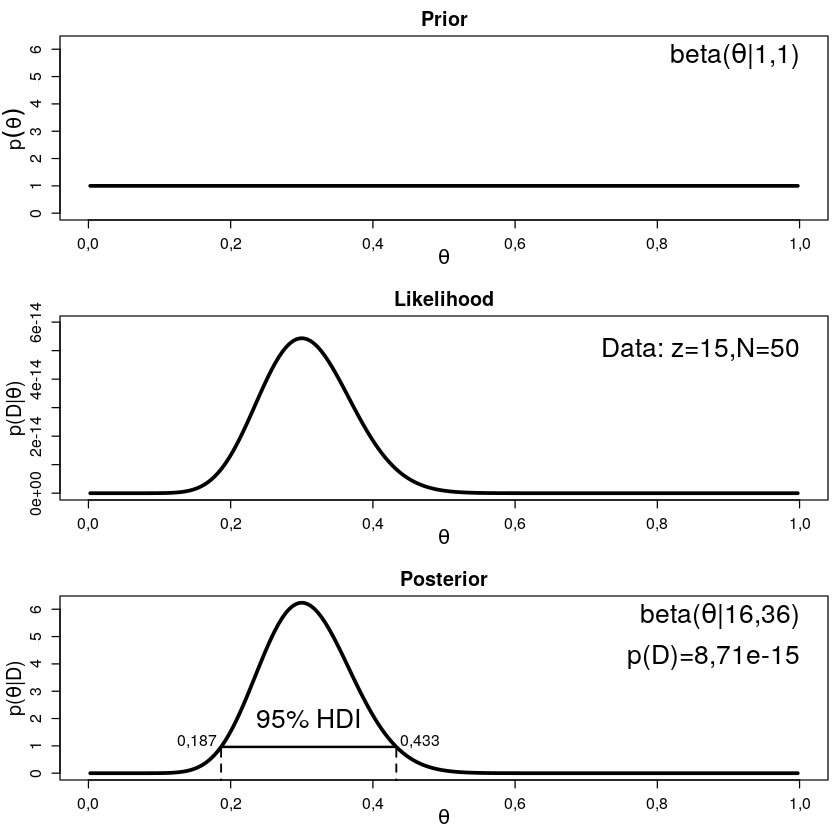

In [62]:
piorShape = c(1,1)
postShape = BernBeta(piorShape, c(rep(c(0), 35), rep(c(1), 15)), plotGraph=T)

### Excercise 5.4

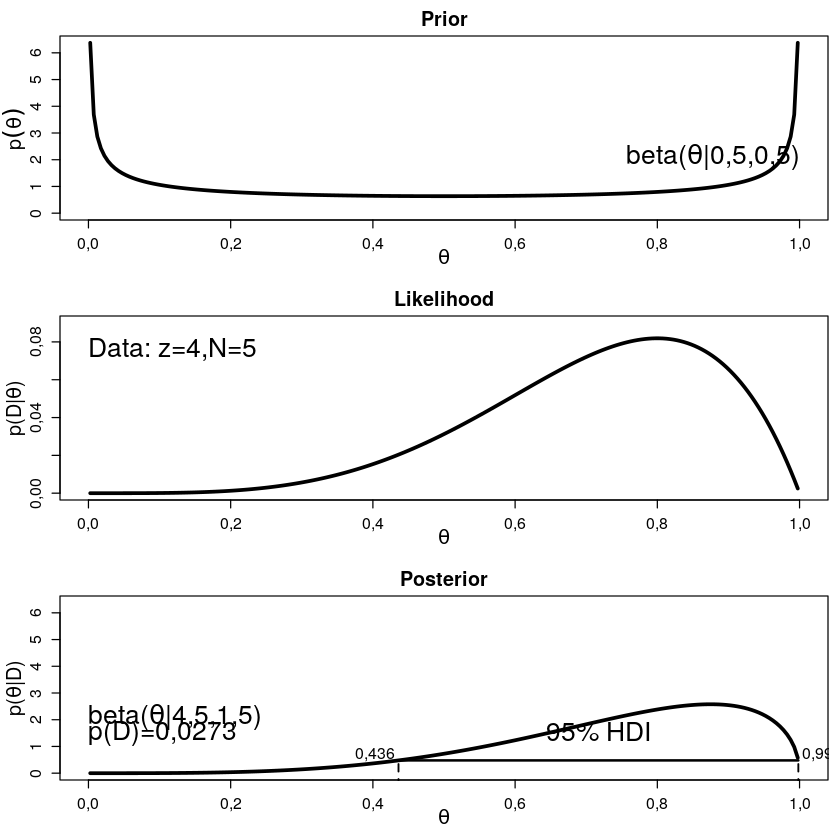

In [64]:
piorShape = c(0.5,0.5)
postShape = BernBeta(piorShape, c(1,1,1,1,0), plotGraph=T)

### Excercise 5.5

#### A

In [73]:
# we have a strong beleive that the coin is fair:
a = 50
b = 50
# posterior data
N = 10
z = 9
# p(y=1) is mean of posterior distribution = (z + a)/(N + a + b)

ex55 = function (a,b,N,z,...) {
    pHeads = (z+a)/(N+a+b)
    cat('Probability of heads for 11th flip is', format(pHeads, digits=3))
}

ex55(a,b,N,z)

Probability of heads for 11th flip is 0,536

#### B

In [74]:
# I think uniform dictribution is the best option
a = 1
b = 1
ex55(a,b,N,z)

Probability of heads for 11th flip is 0,833

### Excersice 5.6

In [81]:
# Fair prior
a = 50
b = 50
# Trick
a2 = 0.5
b2 = 0.5
# Bayes’ factor is p(D|M1)/p(D|M2), so ratio of evidences
bFactor = function(a1, b1, a2, b2, N, z) {
    pData1 = beta(z+a1, N-z+b1)/beta(a1,b1)
    pData2 = beta(z+a2, N-z+b2)/beta(a2,b2)
    res = c(pData1 / pData2, pData1, pData2)
    return(res)
}

f = bFactor(a,b,a2,b2,20,15)
cat('Bayes’ factor (fair/trick) is', f[1])

Bayes’ factor (fair/trick) is 0,5779609

### Excercise 5.7

In [82]:
a1 = 100
b1 = 1
# Trick
a2 = 1
b2 = 100

f=bFactor(a1,b1,a2,b2,1,1)
cat('Bayes’ factor (trick(H)/trick(T)) is', f[1])

Bayes’ factor (trick(H)/trick(T)) is 100

### Excercise 5.8

In [83]:
a1 = 100
b1 = 1
# Trick
a2 = 1
b2 = 100

f=bFactor(a1,b1,a2,b2,12,8)
cat('Bayes’ factor (trick(H)/trick(T)) is', f[1],
    'p(D|trick(H))=', f[2], 'p(D|trick(T))=', f[3])

Bayes’ factor (trick(H)/trick(T)) is 73723 p(D|trick(H))= 1,490827e-07 p(D|trick(T))= 2,022201e-12

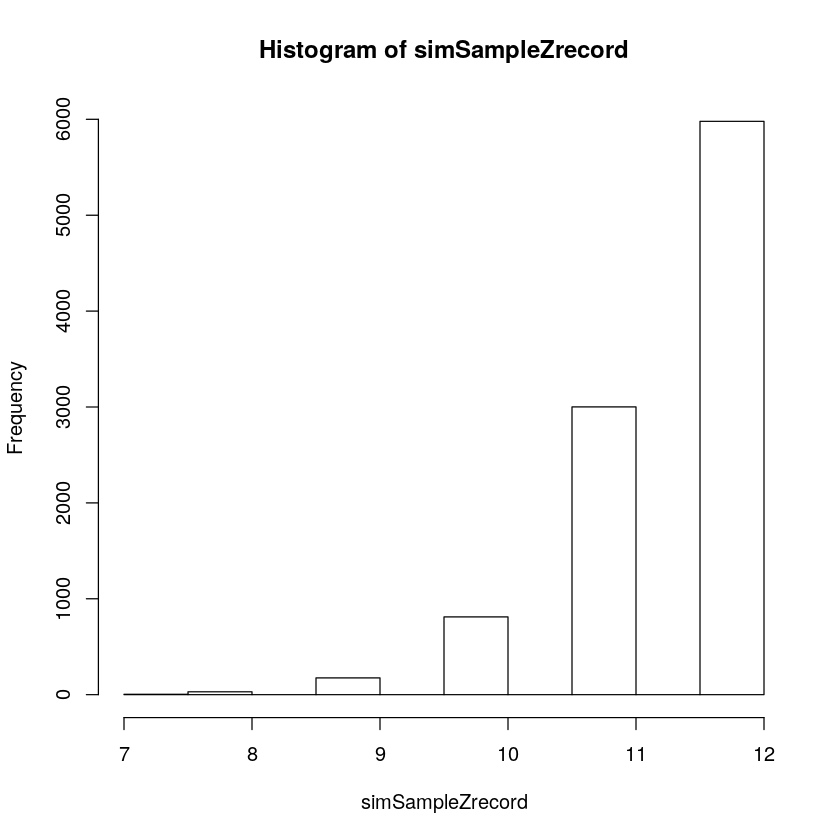

In [87]:
priorA = 100
priorB = 1
actualDataZ = 8
actualDataN = 12

postA = priorA + actualDataZ
postB = priorB + actualDataN - actualDataZ

simSampleSize = actualDataN

nSimSamples = 10000

simSampleZrecord = vector(length=nSimSamples)

for (sampleIdx in 1:nSimSamples) {
    sampleTheta = rbeta(1, postA, postB)
    sampleData = sample(x=c(0,1), prob=c(1-sampleTheta, sampleTheta),
               size=simSampleSize, replace=T)
    simSampleZrecord[sampleIdx] = sum(sampleData)
}

hist(simSampleZrecord)

In [1]:
# install.packages("R2OpenBUGS")
library(R2OpenBUGS)